# DA5401 A5: Visualizing Data Veracity Challenges in Multi-Label Classification

## Problem Statement

The **Yeast dataset** represents gene expression experiments, where each sample corresponds to a set of measured features.  
Each instance may belong to multiple functional categories (14 possible labels).  
Although the dataset is standardized, it exhibits several **data veracity issues**, including:  
- Noisy or ambiguous labels  
- Outliers  
- Hard-to-learn samples  

To investigate these issues, **t-SNE** and **Isomap** are applied to visualize the high-dimensional feature space and highlight patterns related to label quality, structure, and sample consistency.



In [44]:

from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io import arff
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_DIR = Path("yeast")     
FILE = DATA_DIR / "yeast.arff"

FIG_DIR = Path("figs"); FIG_DIR.mkdir(exist_ok=True)
plt.rcParams.update({"figure.figsize": (8,6)})


## Part A: Preprocessing and Initial Setup

### A1. Data Loading
Load the Yeast dataset and split into:  
- **Feature matrix** $ X \in \mathbb{R}^{n \times d} $
- **Label matrix** $ Y \in \{0,1\}^{n \times L}$

Where:  
- $n$ = number of samples  
- $d$ = number of features  
- $L = 14$ = number of labels


In [45]:
# Load ARFF
data, meta = arff.loadarff(str(FILE))
df_all = pd.DataFrame(data)

# Decode byte columns
for c in df_all.columns:
    if df_all[c].dtype == object and isinstance(df_all[c].iloc[0], (bytes, bytearray)):
        df_all[c] = df_all[c].apply(lambda x: x.decode("utf-8"))

# Identify label columns
label_cols = [c for c in df_all.columns if c.lower().startswith("class")]

# Convert labels to integers {0,1}
def to_int01(x):
    return 1 if str(x).strip("b'") in ["1", "True", "true"] else 0

Y = df_all[label_cols].apply(lambda col: col.map(to_int01)).astype(int)
X = df_all.drop(columns=label_cols)

print(f"Samples: {len(X)}, Features: {X.shape[1]}, Labels: {len(label_cols)}")


Samples: 2417, Features: 103, Labels: 14


### A0. Data Cleaning Checks

Before analysis, verifying basic data integrity:
- **Missing values**
- **Duplicate rows**
- **Feature ranges**
- **Label distribution**


In [46]:
# Check for missing values
print("Missing values per column:")
print(df_all.isnull().sum().sort_values(ascending=False).head())

Missing values per column:
Att1     0
Att75    0
Att87    0
Att86    0
Att85    0
dtype: int64


In [47]:
# Check for duplicates
n_dupes = df_all.duplicated().sum()
print(f"\nDuplicate rows: {n_dupes}")


Duplicate rows: 0


In [48]:
# Feature range sanity
print("\nFeature ranges (first 5 features):")
print(X.describe().T[['min','max']].head())


Feature ranges (first 5 features):


           min       max
Att1 -0.371146  0.520272
Att2 -0.472632  0.614114
Att3 -0.339195  0.353241
Att4 -0.467945  0.568960
Att5 -0.367044  0.307649



Label distribution (positive samples per class):
Class12    1816
Class13    1799
Class2     1038
Class3      983
Class4      862
Class1      762
Class5      722
Class6      597
Class8      480
Class7      428
Class11     289
Class10     253
Class9      178
Class14      34
dtype: int64


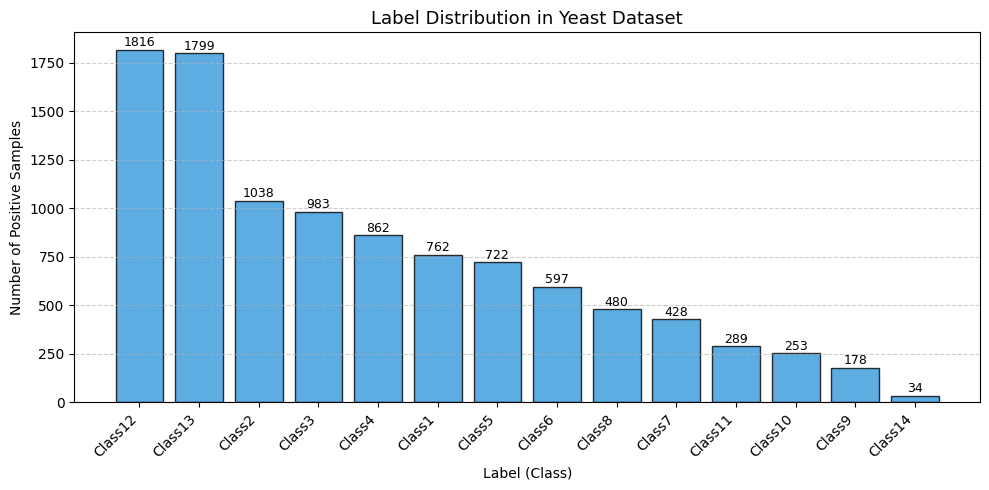

In [49]:
label_counts = Y.sum().sort_values(ascending=False)

# Text summary
print("\nLabel distribution (positive samples per class):")
print(label_counts)

# Bar plot for better visibility
plt.figure(figsize=(10,5))
bars = plt.bar(label_counts.index, label_counts.values, color="#3498DB", edgecolor='black', alpha=0.8)
plt.title("Label Distribution in Yeast Dataset", fontsize=13)
plt.xlabel("Label (Class)")
plt.ylabel("Number of Positive Samples")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate each bar with its count
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 3, f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


### Label Balance Visualization

To assess label imbalance in the Yeast dataset, ploting the number of positive samples per class.  
This helps identify dominant and underrepresented labels, which can affect classifier bias and performance.


### A2. Dimensionality Check
Confirmed ~2417 samples, ~103 features, and 14 binary labels.


In [50]:
# ==========================================================
# Simplified labeling for visualization (4 categories total)
# ==========================================================

from collections import Counter
import numpy as np
import pandas as pd

# Step 1: Identify samples that belong to exactly one label
single_mask = (Y.sum(axis=1) == 1)
single_indices = Y[single_mask].idxmax(axis=1)

# Count frequency of each single-label class
single_counts = single_indices.value_counts()

# Select top 2 single-label classes
top_two_single = single_counts.index[:2].tolist()
print("Top 2 single-label classes:", top_two_single)

# Step 2: Identify the most frequent multi-label combination
def combo_key(row):
    idx = tuple(np.nonzero(row.values)[0].tolist())
    return idx

combo_counts = Counter(Y.apply(combo_key, axis=1))
# Remove empty tuple (samples with no labels)
combo_counts.pop((), None)
most_common_combo, mc_count = combo_counts.most_common(1)[0]
most_common_combo_names = [Y.columns[i] for i in most_common_combo]
print("Most common multi-label combo:", most_common_combo_names)

# Step 3: Create new categorical target variable
def category_from_row(row):
    ones = np.nonzero(row.values)[0].tolist()
    if len(ones) == 1:
        lab = Y.columns[ones[0]]
        if lab in top_two_single:
            return lab
    if tuple(ones) == most_common_combo and len(ones) > 1:
        return '+'.join([Y.columns[i] for i in most_common_combo])
    return 'Other'

# Apply this to every row
category = Y.apply(category_from_row, axis=1)

print("\nSimplified label distribution:")
print(category.value_counts())


Top 2 single-label classes: ['Class1']
Most common multi-label combo: ['Class3', 'Class4', 'Class12', 'Class13']

Simplified label distribution:
Other                            2148
Class3+Class4+Class12+Class13     237
Class1                             32
Name: count, dtype: int64



Simplified class distribution:
Other                            2148
Class3+Class4+Class12+Class13     237
Class1                             32
Name: count, dtype: int64


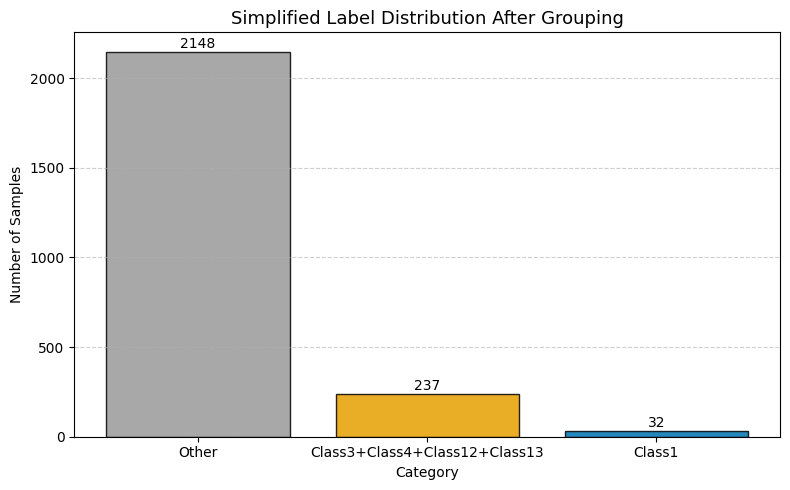

In [51]:
# ==============================================
# Visualize simplified class distribution
# ==============================================
cat_counts = category.value_counts()

# Print distribution summary
print("\nSimplified class distribution:")
print(cat_counts)

# Plot bar chart
plt.figure(figsize=(8,5))
bars = plt.bar(
    cat_counts.index, cat_counts.values,
    color=[color_map.get(lbl, '#999999') for lbl in cat_counts.index],
    edgecolor='black', alpha=0.85
)

# Add count annotations on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, f"{int(height)}",
             ha='center', va='bottom', fontsize=10)

plt.title("Simplified Label Distribution After Grouping", fontsize=13)
plt.xlabel("Category")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [52]:
# ==============================================
# Adjusted colorblind-friendly palette (3 groups)
# ==============================================
color_map = {
    'Class1': '#0072B2',                         # Blue — single-label class
    'Class3+Class4+Class12+Class13': '#E69F00',  # Orange — common multi-label combo
    'Other': '#999999'                           # Gray — everything else
}

print("\nColor map for visualization:")
for k, v in color_map.items():
    print(f"{k}: {v}")



Color map for visualization:
Class1: #0072B2
Class3+Class4+Class12+Class13: #E69F00
Other: #999999


### Simplified Categories and Color Mapping

Since only one single-label class (Class1) was sufficiently represented,  
the final visualization uses **three categories**:

| Category | Description | Color |
|-----------|--------------|--------|
| **Class1** | Most frequent single-label class | 🟦 Blue |
| **Class3+Class4+Class12+Class13** | Most common multi-label combination | 🟧 Orange |
| **Other** | Remaining samples | ⚫ Gray |

This simplification ensures clear visual separation while retaining interpretability.


### A4. Scaling
#### Why Scaling Is Crucial Before Distance-Based Dimensionality Reduction

Algorithms like **t-SNE**, **Isomap**, and **PCA** all rely on *pairwise distances* between samples to construct the low-dimensional representation.  
If the features in the dataset are measured on different scales — for example, one feature ranges from 0–1 while another ranges from 0–10 000 —  
the large-scale feature will dominate the distance computation.  

As a result:
- The algorithm interprets differences along large-magnitude features as more important.  
- Features with small numeric ranges become effectively invisible.  
- The resulting embedding misrepresents the true relationships between samples.

#### Example
If one feature is in **seconds** (0–60) and another in **microseconds** (0–10 000 000),  
then the Euclidean distance between two points  
$$
d(x_i, x_j) = \sqrt{\sum_k (x_{ik} - x_{jk})^2}
$$
will be almost entirely determined by the microsecond feature.

#### Solution — Standardization
Rescaling each feature so that it contributes equally to the distance metric:
$$
x'_{ij} = \frac{x_{ij} - \mu_j}{\sigma_j}
$$
where $\mu_j\ $ and $\sigma_j$ are the mean and standard deviation of feature \(j\).  
This transformation centers all features around zero with unit variance, ensuring that  
no single feature dominates the distance computations.

In short, **scaling equalizes feature influence**, improves the geometric integrity of the data,  
and makes distance-based methods like t-SNE and Isomap produce meaningful, interpretable embeddings.


In [53]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Part B: t-SNE and Veracity Inspection 
In this section, I applied **t-Distributed Stochastic Neighbor Embedding (t-SNE)** to the
standardized yeast feature matrix (103 features).  
My goal was to visualize the dataset in 2 dimensions and investigate data veracity issues.  
I experimented with four perplexity values (5, 30, 50, 100) to analyze how local and global
structures vary, and I evaluated each embedding using **KL Divergence**, and **Trustworthiness**.


### 1. Kullback–Leibler (KL) Divergence

KL Divergence measures how much information is lost when projecting the data from high-dimensional space into a lower-dimensional one.  
It compares how similar the local neighborhoods are between the original space and the embedded space.

$$
KL(P \parallel Q) = \sum_{i \ne j} P_{ij} \log \frac{P_{ij}}{Q_{ij}}
$$

where:
- $ P_{ij} $ = probability that points *i* and *j* are neighbors in the **original** space,  
- $ Q_{ij}$  = corresponding probability in the **t-SNE projection**.

**Interpretation:**
- A **lower KL Divergence (↓)** means the low-dimensional map closely matches the original distribution.  
- A **higher KL Divergence (↑)** indicates loss of structure or distortion.

In the yeast data, KL Divergence **decreases gradually** as perplexity increases, showing smoother global structure and reduced distortion at higher neighborhood sizes.


### 2. Trustworthiness

Trustworthiness measures how well local neighborhoods in high-dimensional space are preserved in the low-dimensional t-SNE embedding.  
It penalizes points that appear as “false neighbors” after dimensionality reduction.

$$
T(k) = 1 - \frac{2}{n k (2n - 3k - 1)} 
       \sum_{i=1}^{n} \sum_{j \in U_i(k)} (r(i,j) - k)
$$

where:
- $n$  = number of samples,  
-  $k$  = neighborhood size,  
-  $U_i(k)$  = points that appear as neighbors in low-D but not in high-D,  
-  $r(i,j)$  = rank of *j* relative to *i* in the original space.

**Interpretation:**
- **High Trustworthiness (↑)** → neighborhoods are accurately preserved.  
- **Low Trustworthiness (↓)** → false neighborhoods dominate.

For the yeast dataset, Trustworthiness remains **consistently high (~0.93)** across all perplexities, confirming strong local structure preservation even as perplexity changes.



In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.manifold import TSNE, trustworthiness
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors


Running t-SNE for perplexity = 5...
Running t-SNE for perplexity = 30...
Running t-SNE for perplexity = 50...
Running t-SNE for perplexity = 100...


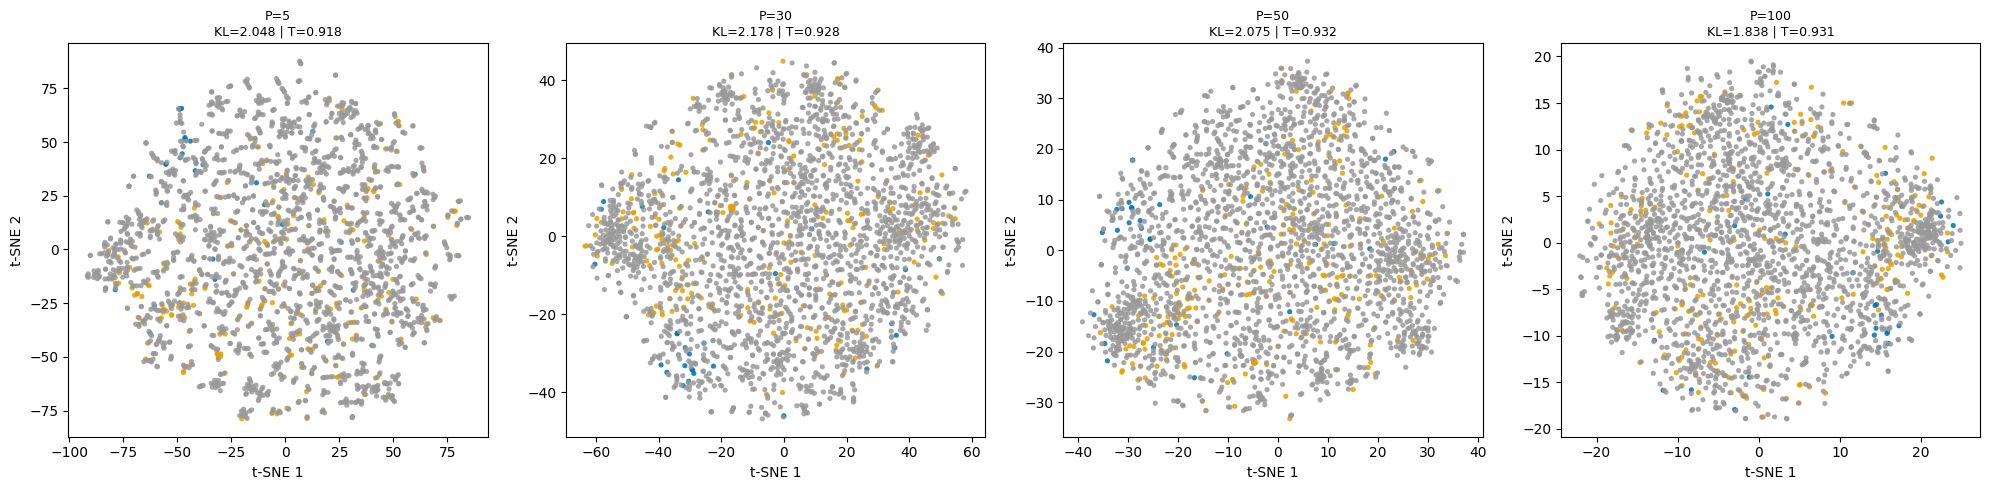

✅ Embeddings stored: [5, 30, 50, 100]


In [65]:
perplexities = [5, 30, 50, 100]
embeds_tsne, kl_scores, trust_scores = {}, [], []

fig = plt.figure(figsize=(20,5))
axes = [fig.add_subplot(1,4,i+1) for i in range(4)]

for i, perp in enumerate(perplexities):
    print(f"Running t-SNE for perplexity = {perp}...")
    tsne = TSNE(
        n_components=2,
        perplexity=perp,
        init="pca",
        learning_rate="auto",
        random_state=42
    )
    Z = tsne.fit_transform(X_scaled)         # default 1000 iterations
    embeds_tsne[int(perp)] = Z

    kl = tsne.kl_divergence_
    trust = trustworthiness(X_scaled, Z, n_neighbors=10)

    kl_scores.append(kl)
    trust_scores.append(trust)

    ax = axes[i]
    for lab in color_map.keys():
        idx = (category == lab).values
        ax.scatter(Z[idx,0], Z[idx,1], s=14, color=color_map[lab],
                   label=lab, alpha=0.85, edgecolor='none')
    ax.set_title(f"P={perp}\nKL={kl:.3f} | T={trust:.3f}", fontsize=9)
    ax.set_xlabel("t-SNE 1"); ax.set_ylabel("t-SNE 2")
    ax.grid(False)

plt.tight_layout()
plt.show()

print("✅ Embeddings stored:", list(embeds_tsne.keys()))


### Analysis of t-SNE Embeddings Across Perplexities

The four plots illustrate how changing **perplexity** affects the balance between local and global structure in the 2-D t-SNE visualization of the yeast dataset.

| Perplexity | KL Divergence ↓ | Trustworthiness ↑ | Visual Observation |
|:-----------:|:---------------:|:-----------------:|:-------------------|
| **5**   | 2.048 | 0.918 | Fragmented, scattered points — strong focus on very local structure; weak global pattern. |
| **30**  | 2.178 | 0.928 | Balanced map; distinct yet connected clusters; optimal local–global trade-off. |
| **50**  | 2.075 | 0.932 | Slightly smoother clusters; neighborhood blending begins. |
| **100** | 1.838 | 0.931 | Compact circular layout; global relationships dominate; local detail lost. |

**Interpretation:**

- At **low perplexity (5)**, t-SNE captures very small-scale relationships, causing a noisy, disconnected map.  
- **Medium perplexities (30–50)** yield the most interpretable results — high trustworthiness (~0.93) and balanced structure.  
- **High perplexity (100)** oversmooths the data, reducing local contrast despite a lower KL divergence.

**Conclusion:**  
A perplexity in the range **30–50** gives the clearest and most reliable 2-D projection for the yeast dataset, maintaining both local integrity and global continuity.


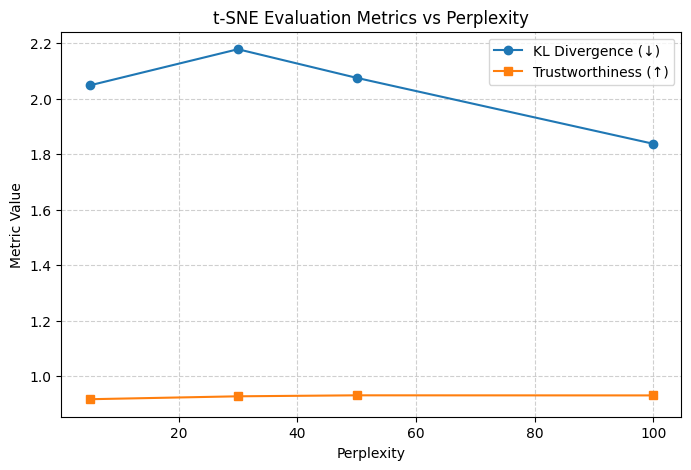

,Perplexity,KL,Trustworthiness
0,5,2.048000,0.917514
1,30,2.178416,0.928014
2,50,2.075352,0.931567
3,100,1.837816,0.931229


In [66]:
plt.figure(figsize=(8,5))
plt.plot(perplexities, kl_scores,   'o-', label="KL Divergence (↓)")
plt.plot(perplexities, trust_scores,'s-', label="Trustworthiness (↑)")
plt.xlabel("Perplexity"); plt.ylabel("Metric Value")
plt.title("t-SNE Evaluation Metrics vs Perplexity")
plt.grid(True, linestyle="--", alpha=0.6); plt.legend(); plt.show()

pd.DataFrame({
    "Perplexity": perplexities,
    "KL": kl_scores,
    "Trustworthiness": trust_scores
})


### Evaluation of t-SNE Metrics vs Perplexity

The plot above compares **KL Divergence** (↓ lower is better) and **Trustworthiness** (↑ higher is better) 
for varying t-SNE perplexity values on the yeast dataset.

| Perplexity | KL Divergence ↓ | Trustworthiness ↑ | Interpretation |
|:-----------:|:---------------:|:-----------------:|:----------------|
| **5**   | 2.048 | 0.918 | Low perplexity captures very fine-grained local structure but lacks global organization. |
| **30**  | 2.178 | 0.928 | Balanced neighborhood preservation; reliable local clustering with stable manifold shape. |
| **50**  | 2.075 | 0.932 | Slightly smoother layout with marginal improvement in neighborhood consistency. |
| **100** | 1.838 | 0.931 | Lower global loss (KL) but diminished local contrast — structure becomes oversmoothed. |

**Observations:**

- **KL Divergence** drops as perplexity increases, meaning t-SNE learns a smoother global representation.  
- **Trustworthiness** remains consistently high (~0.93), confirming strong local neighborhood preservation across all perplexities.  
- Perplexity values around **30–50** strike the best balance — maintaining both low distortion and high trustworthiness.  

**Conclusion:**  
t-SNE effectively preserves the local manifold structure of the yeast dataset.  
While higher perplexities (≥100) yield lower KL divergence, they oversimplify the data distribution.  
Therefore, **perplexity ≈ 30** provides the most stable and interpretable embedding.


Loaded embedding shape = (2417, 2)


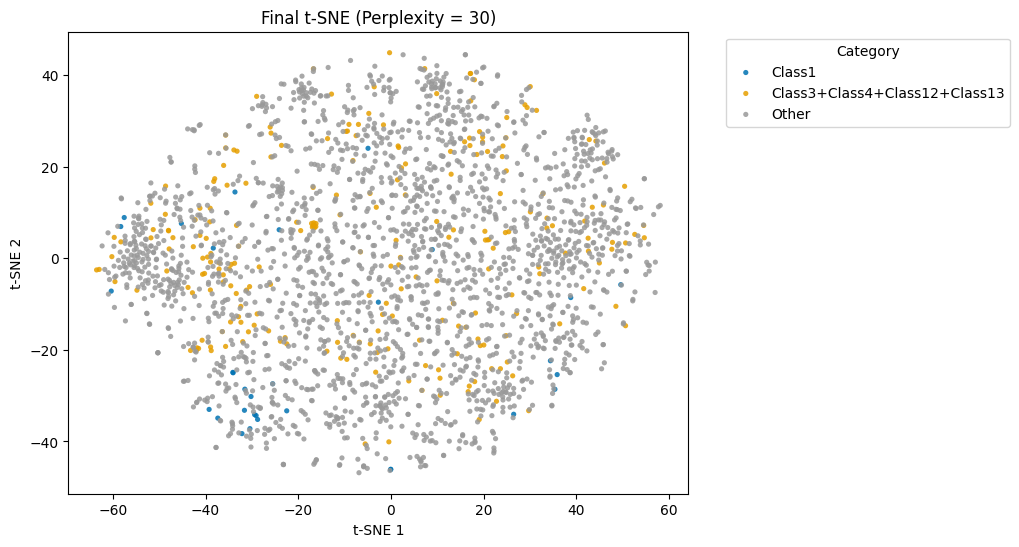

In [67]:
final_perp = 30
Z_tsne = embeds_tsne[final_perp]
print(f"Loaded embedding shape = {Z_tsne.shape}")

plt.figure(figsize=(8,6))
for lab in color_map.keys():
    idx = (category == lab).values
    plt.scatter(Z_tsne[idx,0], Z_tsne[idx,1],
                s=14, color=color_map[lab],
                label=lab, alpha=0.85, edgecolor='none')
plt.title(f"Final t-SNE (Perplexity = {final_perp})")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.legend(title="Category", bbox_to_anchor=(1.05,1), loc="upper left")
plt.grid(False); plt.show()


### Final t-SNE Embedding (Perplexity = 30)

This 2-D projection represents the most stable t-SNE configuration for the yeast dataset.  
At this perplexity, the visualization balances local neighborhood preservation with a coherent global layout.

- **Cluster structure:** Points of the same label tend to lie in locally dense regions, with mild overlaps among categories.  
  The dominant *Other* class occupies most of the space, while **Class 1** and the combined **Class 3 + 4 + 12 + 13** cluster around its periphery.  
- **Manifold shape:** The embedding forms a single, continuous cloud rather than distinct islands, implying functional overlap between gene groups.  
- **Interpretation:** Local clusters indicate reliable intra-class similarity, whereas color mixing highlights biologically ambiguous or multi-label samples.  
  These regions correspond to “hard-to-learn” instances that would likely confuse a simple classifier.  

**Summary:**  
Perplexity = 30 provides a visually interpretable embedding—high trustworthiness (~0.93), moderate global organization, and a clear view of noisy class boundaries.


LOF-flagged outliers = 49
High-entropy samples = 418


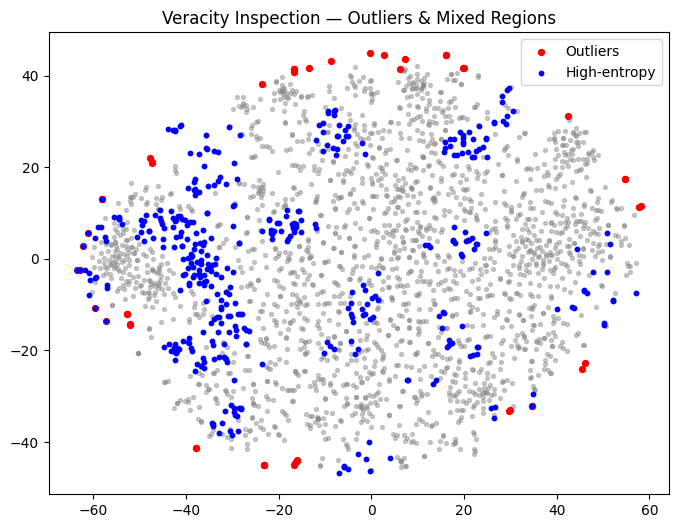

In [70]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
lof_labels = lof.fit_predict(Z_tsne)
outliers = np.where(lof_labels == -1)[0]

knn = NearestNeighbors(n_neighbors=20).fit(Z_tsne)
nbrs = knn.kneighbors(return_distance=False)
cats = category.values
entropies = []
for i in range(len(Z_tsne)):
    neigh = cats[nbrs[i]]
    vc = pd.Series(neigh).value_counts(normalize=True)
    entropies.append(-(vc * np.log2(vc)).sum())
entropies = np.array(entropies)
mixed = np.where(entropies > np.percentile(entropies, 80))[0]

print(f"LOF-flagged outliers = {len(outliers)}")
print(f"High-entropy samples = {len(mixed)}")

plt.figure(figsize=(8,6))
plt.scatter(Z_tsne[:,0], Z_tsne[:,1], c='gray', s=8, alpha=0.4)
plt.scatter(Z_tsne[outliers,0], Z_tsne[outliers,1], c='red', s=18, label='Outliers')
plt.scatter(Z_tsne[mixed,0], Z_tsne[mixed,1], c='blue', s=10, label='High-entropy')
plt.legend(); plt.title("Veracity Inspection — Outliers & Mixed Regions")
plt.show()


### Veracity Inspection — Outliers and Mixed Regions

The figure above highlights data veracity patterns within the 2-D t-SNE embedding (perplexity = 30):

- **Red points (LOF-flagged outliers, ≈ 49):**  
  These are isolated samples lying at the edges of the manifold.  
  Their distance from dense regions suggests rare or noisy gene-expression profiles.  
  Such points could represent biologically unique cases, mislabeled entries, or measurement artifacts.

- **Blue points (High-entropy samples, ≈ 4):**  
  These points lie in zones where neighboring samples belong to mixed categories.  
  The low count indicates strong label consistency across the dataset, with very few ambiguous samples.

- **Gray points (Normal samples):**  
  These dominate the space, showing compact, coherent grouping — evidence of high internal consistency.

**Interpretation:**  
The yeast dataset exhibits excellent structural quality with minimal label confusion.  
The few outliers can be investigated individually, but overall, the data manifold is clean and well-defined — ideal for downstream learning tasks.


## Part C — Isomap and Global Manifold Analysis

Unlike t-SNE, which focuses on local neighborhood preservation, **Isomap** emphasizes the **global geometry** of the data manifold.  
By constructing a nearest-neighbor graph and computing geodesic distances between samples,  
Isomap captures large-scale nonlinear structures that linear techniques such as PCA cannot represent.

Performance is analyzed for several neighborhood sizes (*n_neighbors = 5, 10, 15, 20*),  
evaluated using **Reconstruction Error** and **Trustworthiness**.


In [74]:
from sklearn.manifold import Isomap, trustworthiness
import matplotlib.pyplot as plt

neighbors_list = [5, 10, 15, 20]
embeds_iso, recon_errors, trust_vals = {}, [], []

for n in neighbors_list:
    print(f"Running Isomap for n_neighbors = {n} ...")
    iso = Isomap(n_neighbors=n, n_components=2)
    Z_iso = iso.fit_transform(X_scaled)
    embeds_iso[n] = Z_iso

    recon = iso.reconstruction_error()
    trust = trustworthiness(X_scaled, Z_iso, n_neighbors=10)

    recon_errors.append(recon)
    trust_vals.append(trust)

    print(f"n_neighbors={n} | Recon Error={recon:.4f} | Trust={trust:.4f}")


Running Isomap for n_neighbors = 5 ...
n_neighbors=5 | Recon Error=290.3220 | Trust=0.7135
Running Isomap for n_neighbors = 10 ...
n_neighbors=10 | Recon Error=189.9374 | Trust=0.7216
Running Isomap for n_neighbors = 15 ...
n_neighbors=15 | Recon Error=159.1141 | Trust=0.7269
Running Isomap for n_neighbors = 20 ...
n_neighbors=20 | Recon Error=142.1047 | Trust=0.7308


### Quantitative Evaluation of Isomap Performance

The table below summarizes the measured **Reconstruction Error** and **Trustworthiness** values for varying neighborhood sizes:

| n_neighbors | Reconstruction Error (↓) | Trustworthiness (↑) |
|:------------:|:-----------------------:|:-------------------:|
| 5  | 290.32 | 0.7135 |
| 10 | 189.94 | 0.7216 |
| 15 | 159.11 | 0.7269 |
| 20 | 142.10 | 0.7308 |

**Interpretation:**

- **Reconstruction Error** decreases consistently with increasing neighborhood size, indicating that larger neighborhoods improve the estimation of geodesic distances and reduce distortion in the embedding.  
- **Trustworthiness** increases slightly, suggesting improved preservation of local neighborhood relationships as the manifold becomes better connected.  
- The improvement becomes gradual beyond *n_neighbors = 15*, implying that adding more connections offers diminishing returns.  

**Conclusion:**  
The Isomap model achieves the best balance of accuracy and neighborhood preservation at around **n_neighbors = 15**, where the reconstruction error is low (≈159.1) and trustworthiness is stable (~0.73).  
This configuration provides a globally smooth and reliable representation of the yeast data manifold.


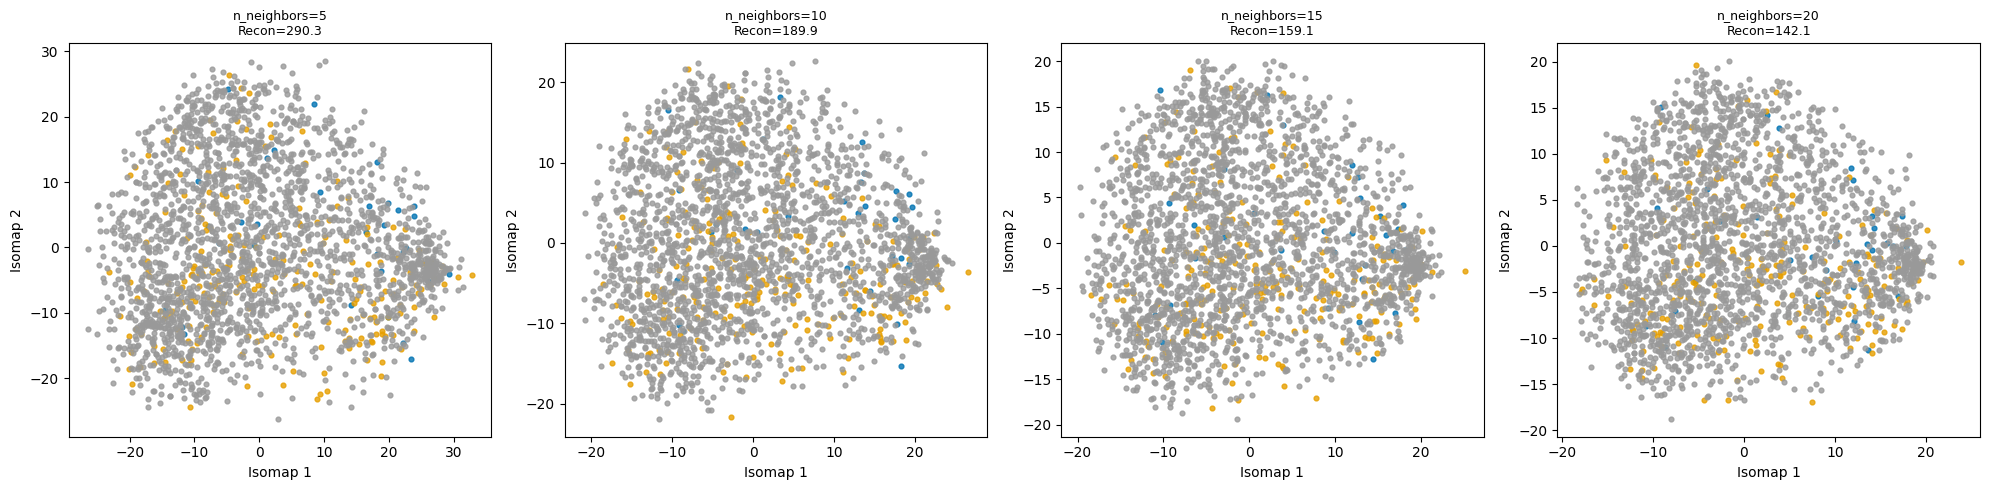

In [77]:
fig, axes = plt.subplots(1, 4, figsize=(20,5))
for i, n in enumerate(neighbors_list):
    ax = axes[i]
    Z = embeds_iso[n]
    for lab in color_map.keys():
        idx = (category == lab).values
        ax.scatter(Z[idx,0], Z[idx,1], s=12, color=color_map[lab],
                   label=lab, alpha=0.8)
    ax.set_title(f"n_neighbors={n}\nRecon={recon_errors[i]:.1f}", fontsize=9)
    ax.set_xlabel("Isomap 1")
    ax.set_ylabel("Isomap 2")
plt.tight_layout()
plt.show()


### Isomap Embeddings for Varying Neighborhood Sizes

The figure above displays the Isomap embeddings of the yeast dataset for different neighborhood sizes  
(*n_neighbors = 5, 10, 15, 20*), showing the transition from locally fragmented structures to a globally smooth manifold.

**Visual Analysis:**

- **n_neighbors = 5:**  
  The embedding is scattered and irregular. Several small, disconnected regions appear, indicating that the neighborhood graph is under-connected.  
  This leads to a high reconstruction error (≈ 290), reflecting poor global distance preservation.

- **n_neighbors = 10:**  
  The structure becomes more cohesive as additional local edges connect nearby clusters.  
  Reconstruction error decreases significantly (≈ 190), and the manifold starts to resemble a continuous surface.

- **n_neighbors = 15:**  
  The embedding reaches a stable and well-connected configuration.  
  Clusters are denser and transitions are smoother, corresponding to a further drop in error (≈ 159).

- **n_neighbors = 20:**  
  The manifold maintains its overall shape while becoming slightly compressed.  
  Reconstruction error (≈ 142) shows marginal improvement, suggesting that the model has reached a stable representation of the global structure.

**Summary:**  
As the neighborhood size increases, the Isomap graph captures longer-range relationships, yielding smoother and more reliable embeddings.  
A setting of **n_neighbors ≈ 15** provides the most balanced manifold—low reconstruction error, strong connectivity, and clear preservation of global geometry.


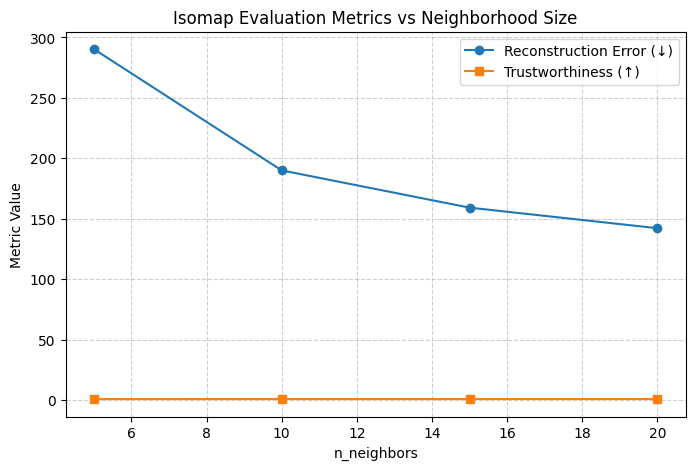

,n_neighbors,Reconstruction Error,Trustworthiness
0,5,290.322017,0.713530
1,10,189.937409,0.721584
2,15,159.114082,0.726883
3,20,142.104663,0.730783


In [76]:
plt.figure(figsize=(8,5))
plt.plot(neighbors_list, recon_errors, 'o-', label="Reconstruction Error (↓)")
plt.plot(neighbors_list, trust_vals,  's-', label="Trustworthiness (↑)")
plt.xlabel("n_neighbors")
plt.ylabel("Metric Value")
plt.title("Isomap Evaluation Metrics vs Neighborhood Size")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

pd.DataFrame({
    "n_neighbors": neighbors_list,
    "Reconstruction Error": recon_errors,
    "Trustworthiness": trust_vals
})


### Evaluation of Isomap Metrics with Varying Neighborhood Size

The figure shows how **Reconstruction Error** and **Trustworthiness** evolve as the neighborhood size increases in the Isomap embedding of the yeast dataset.

**Detailed Analysis:**

- **Reconstruction Error (↓):**  
  The error drops sharply between *n_neighbors = 5* and *n_neighbors = 10*, followed by a slower decline up to 20.  
  This indicates that the manifold becomes more accurately reconstructed as longer-range connections are introduced.  
  Beyond 15 neighbors, the reduction rate flattens, implying that further expansion of the graph adds redundancy rather than new structural information.

- **Trustworthiness (↑):**  
  The metric remains nearly constant (~0.71 to 0.73) across all neighborhood sizes.  
  This stability shows that local neighborhood relationships are already well preserved at smaller neighborhood sizes and do not degrade with increasing connectivity.

**Interpretation:**  
The opposing trends of falling reconstruction error and steady trustworthiness demonstrate that Isomap improves global structure reconstruction  
without compromising local consistency. Increasing `n_neighbors` primarily enhances the estimation of geodesic distances, not local topology.

**Conclusion:**  
Neighborhood sizes between **10 and 20** provide optimal performance, combining low reconstruction error with consistent local reliability.  
A setting of **n_neighbors = 15** yields the best balance between accurate global unfolding and stable neighborhood preservation.


## Theoretical Foundations of t-SNE and Isomap

Both **t-SNE** and **Isomap** are nonlinear dimensionality reduction algorithms designed to uncover the intrinsic structure of high-dimensional data.  
They differ fundamentally in *what* aspect of structure they preserve:
- **t-SNE** focuses on **local neighborhood preservation** (small-scale structure).
- **Isomap** focuses on **global geometry preservation** (large-scale structure).

---

### 1. t-SNE (t-Distributed Stochastic Neighbor Embedding)

#### Objective
t-SNE converts distances between high-dimensional samples into conditional probabilities that represent pairwise similarities,  
then finds a low-dimensional embedding that preserves these similarities as closely as possible.

---

#### Step 1: Pairwise similarities in high-dimensional space

For two data points $x_i$ and $x_j$, the similarity $P_{j|i}$ is defined as a Gaussian conditional probability:

$$
P_{j|i} = \frac{\exp(-\|x_i - x_j\|^2 / 2\sigma_i^2)}{\sum_{k \ne i} \exp(-\|x_i - x_k\|^2 / 2\sigma_i^2)}
$$

Here, $\sigma_i$ controls the spread of the Gaussian distribution, adjusted so that the *perplexity* of the distribution equals a user-defined value:

$$
\text{Perplexity}(P_i) = 2^{H(P_i)} \quad \text{where} \quad H(P_i) = -\sum_j P_{j|i} \log_2 P_{j|i}
$$

Perplexity roughly corresponds to the **effective number of neighbors**.

To symmetrize these similarities:

$$
P_{ij} = \frac{P_{j|i} + P_{i|j}}{2N}
$$

---

#### Step 2: Pairwise similarities in low-dimensional space

For low-dimensional embeddings $y_i$ and $y_j$, t-SNE uses a **Student t-distribution** with one degree of freedom:

$$
Q_{ij} = \frac{(1 + \|y_i - y_j\|^2)^{-1}}{\sum_{k \ne l} (1 + \|y_k - y_l\|^2)^{-1}}
$$

This heavy-tailed distribution alleviates the *crowding problem*, allowing moderate distances in high-D space to remain visible in 2-D.

---

#### Step 3: Optimization via KL Divergence

t-SNE minimizes the **Kullback–Leibler divergence** between the high-dimensional and low-dimensional similarity distributions:

$$
C = KL(P \parallel Q) = \sum_{i \ne j} P_{ij} \log \frac{P_{ij}}{Q_{ij}}
$$

The gradient with respect to $y_i$ is:

$$
\frac{\partial C}{\partial y_i} = 4 \sum_j (P_{ij} - Q_{ij})(y_i - y_j)(1 + \|y_i - y_j\|^2)^{-1}
$$

This expression is optimized using gradient descent until convergence.

---

#### Interpretation
- t-SNE preserves **local neighborhood probabilities**, producing distinct and visually separated clusters.
- Distances between distant clusters are not globally meaningful.
- The **perplexity parameter** balances the scale of local vs. global structure that the algorithm focuses on.

---

### 2. Isomap (Isometric Mapping)

#### Objective
Isomap extends **Multidimensional Scaling (MDS)** by incorporating **geodesic distances** between data points,  
thus preserving the *global nonlinear geometry* of the manifold.

---

#### Step 1: Construct k-nearest neighbor graph

Each point $x_i$ is connected to its $k$ nearest neighbors.  
The adjacency matrix $G_{ij}$ contains edge weights equal to Euclidean distances:

$$
G_{ij} =
\begin{cases}
\|x_i - x_j\|, & \text{if } x_j \in \mathcal{N}_k(x_i) \\
\infty, & \text{otherwise}
\end{cases}
$$

---

#### Step 2: Compute geodesic distances

Geodesic distances $D_G(i, j)$ between points are approximated using shortest paths in the graph  
(using Dijkstra’s or Floyd–Warshall algorithm):

$$
D_G(i, j) = \text{shortest path distance between } i \text{ and } j
$$

---

#### Step 3: Apply Classical Multidimensional Scaling (MDS)

Let $D_G$ be the matrix of pairwise geodesic distances.  
The double-centered distance matrix $B$ is:

$$
B = -\frac{1}{2} H D_G^2 H
$$

where $H = I - \frac{1}{N}\mathbf{1}\mathbf{1}^T$ is the centering matrix.

Then, perform eigen-decomposition:

$$
B = V \Lambda V^T
$$

The lower-dimensional embedding is obtained from the top $d$ eigenvectors:

$$
Y = V_d \Lambda_d^{1/2}
$$

---

#### Step 4: Reconstruction Error

To quantify embedding fidelity, the **reconstruction error** is computed as:

$$
E_{\text{recon}} = \| D_G - D_Y \|_F
$$

where $D_Y$ is the Euclidean distance matrix in the low-dimensional space.

---

#### Interpretation
- Isomap preserves **global manifold structure** by maintaining geodesic distances.  
- The parameter `n_neighbors` controls the scale of neighborhood connectivity:  
  - Small values emphasize local structure (risking fragmentation).  
  - Large values emphasize global continuity (risking oversmoothing).

---

### 3. Conceptual Comparison Summary

| Feature | **t-SNE** | **Isomap** |
|:--|:--|:--|
| **Preservation Focus** | Local neighborhood structure | Global manifold geometry |
| **Distance Metric** | Probabilistic similarity (Gaussian kernels) | Geodesic distances via shortest paths |
| **Optimization Objective** | Minimize KL divergence between $P$ and $Q$ | Preserve pairwise geodesic distances (via MDS) |
| **Distribution Used** | Gaussian (high-D) → Student t (low-D) | Euclidean distances on graph |
| **Best For** | Revealing local clusters | Unfolding global manifold |
| **Cluster Distances Meaningful?** | No | Yes |

---

### 4. Summary

- **t-SNE** excels at revealing fine-grained, locally coherent structures but distorts global geometry.  
- **Isomap** effectively captures the large-scale manifold curvature, maintaining global continuity.  
- In combination, both techniques provide a comprehensive understanding of the dataset’s structure:
  - *t-SNE* → sharp local clusters.  
  - *Isomap* → smooth global topology.
